# Figure generation

**Purpose:** This script is used to generate the figures for publication.

**Dependency:** `get_experimental_CAS_ECOSAR.ipynb`, `download_wandb_artifacts.ipynb`, `Train_final_models.ipynb`

**Consecutive scripts:** None

## Imports

In [1]:
from figure_utils.trident_figures import PlotKFoldSingleBarUsingWAvgPreds, PlotKFoldComboBarUsingWAvgPreds, PlotKFoldResidualHistUsingWAvgPreds
from figure_utils.trident_figures import PlotBaseModelLossfunResults, PlotPCA_CLSProjection
from figure_utils.trident_figures import PlotQSARresidualScatter, PlotQSARcompBarUsingWAvgPredsInterersect, PlotQSARcompScatter, PlotQSARCoverageComboBar, PlotQSARComp3inOne
from figure_utils.preprocess_data import Preprocess10x10Fold, GroupDataForPerformance
from figure_utils.preprocess_qsar import LoadQSAR, MatchQSAR, PrepareQSARData

In [2]:
import numpy as np
import pandas as pd

## Make figures

### Non species specific

In [ ]:
INSIDE_AD = True
ENDPOINT = 'EC50'

if INSIDE_AD:
    AD = 'AD'
else:
    AD = 'allpreds'

SAVE_FIGURES = False

if SAVE_FIGURES == True:
    PlotQSARComp3inOne(savepath = f"./figures_for_publication/{ENDPOINT}/allspecies_weightedavgpreds_10x10CV_QSAR_comp_{AD}_SMILES_effect", endpoint=ENDPOINT,inside_AD=INSIDE_AD,use_weighted_avg=True)
else:
    PlotQSARComp3inOne(savepath = None, endpoint=ENDPOINT,inside_AD=INSIDE_AD,use_weighted_avg=True)

### Non endpoint specific

In [3]:
def PlotNonEndpointSpecific(combomodel, species_group, save_figures: bool=False):

    if save_figures:

        PlotKFoldComboBarUsingWAvgPreds(f"./figures_for_publication/combo_model_{combomodel}_performance_10x10_CV", combomodel, species_group)
        PlotKFoldSingleBarUsingWAvgPreds(f"./figures_for_publication/{species_group}_single_model_performance_10x10_CV", ec50_name=f'EC50_{species_group}', ec10_name=f'EC10_{species_group}')
        for inside_AD in [True, False]:
            if inside_AD:
                AD='AD'
            else:
                AD='allpreds'

            PlotQSARCoverageComboBar(f"./figures_for_publication/{species_group}_QSAR_coverage_comparison_{AD}", inside_AD=inside_AD, species_group=species_group)
        if species_group == 'fish':        
            PlotBaseModelLossfunResults(f"./figures_for_publication/base_model_and_lossfun")
    else:

        PlotKFoldComboBarUsingWAvgPreds(None, combomodel, species_group)
        PlotKFoldSingleBarUsingWAvgPreds(None, ec50_name=f'EC50_{species_group}', ec10_name=f'EC10_{species_group}')
        for inside_AD in [True, False]:
            if inside_AD:
                AD='AD'
            else:
                AD='allpreds'

            PlotQSARCoverageComboBar(None, inside_AD=inside_AD, species_group=species_group)
        if species_group == 'fish':        
            PlotBaseModelLossfunResults(None)
        
    

In [3]:
SPECIES_GROUP = 'fish'

In [ ]:
PlotNonEndpointSpecific(f'EC50EC10_{SPECIES_GROUP}_withoverlap', species_group = SPECIES_GROUP, save_figures=True)

### Endpoint-specific

In [4]:
def PlotEndpointSpecific(endpoint, effect_for_qsar_comp, name, inside_AD, durations, species_group, save_figures: bool=False):
    if inside_AD:
        AD='AD'
    else:
        AD='allpreds'
    if effect_for_qsar_comp == ['all']:
        effect_for_qsar_comp = ['MOR','DVP','ITX','MPH','REP','POP','GRO']

    # ----------- TRIDENT ------------------------
    avg_predictions = Preprocess10x10Fold(name=name)
    avg_predictions = avg_predictions[avg_predictions.effect.isin(effect_for_qsar_comp)]
    weighted_avg_predictions = GroupDataForPerformance(avg_predictions=avg_predictions)
    _, mean_L1, median_L1, RMSE, se = (weighted_avg_predictions.residuals, 
                                    weighted_avg_predictions.L1error.mean(), 
                                    weighted_avg_predictions.L1error.median(),
                                    np.sqrt((weighted_avg_predictions.residuals**2).mean()),
                                    np.std(weighted_avg_predictions.L1error)/np.sqrt(len(weighted_avg_predictions))
                                    )
    print(f'''
    (weighted avg) Avg prediction error: {mean_L1}
    (weighted avg) Median prediction error: {median_L1}
    (weighted avg) RMSE: {RMSE}
    (weighted avg) standard error: {se}
    ''')

    if save_figures:
        PlotKFoldResidualHistUsingWAvgPreds(f"./figures_for_publication/{endpoint}/{name}_weightedavgpreds_10x10fold_hist", name=name, endpoint=endpoint, species_group=species_group)
    else:
        PlotKFoldResidualHistUsingWAvgPreds(savepath=None, name=name, endpoint=endpoint, species_group=species_group)

    # ----------- QSAR ------------------------
    ECOSAR, VEGA, TEST = LoadQSAR(endpoint=endpoint, species_group=species_group)
    ECOSAR, TEST, VEGA = PrepareQSARData(ECOSAR, TEST, VEGA, inside_AD=inside_AD, remove_experimental=True, species_group=species_group)
    TEST_dict = dict(zip(TEST.Canonical_SMILES_figures, TEST.value))
    VEGA_dict = dict(zip(VEGA.Canonical_SMILES_figures, VEGA.value))
    ECOSAR_dict = dict(zip(ECOSAR.Canonical_SMILES_figures, ECOSAR.value))

    qsar_preds = MatchQSAR(avg_predictions, ECOSAR_dict, TEST_dict, VEGA_dict, endpoint=endpoint, duration=durations, species_group=species_group)
    qsar_preds[['ECOSAR_residuals','VEGA_residuals','TEST_residuals']] = qsar_preds[['ECOSAR','VEGA','TEST']] - qsar_preds[['labels']].to_numpy()
    weighted_avg_qsar_preds = GroupDataForPerformance(qsar_preds)
    if (endpoint == 'EC10') | (species_group=='algae'):
        weighted_avg_qsar_preds[['TEST', 'TEST_residuals']] = None
    
    if save_figures:
        PlotQSARcompBarUsingWAvgPredsInterersect(f"./figures_for_publication/{endpoint}/{name}_weightedavgpreds_10x10CV_QSAR_comp_{AD}_SMILES_{''.join(effect_for_qsar_comp)}_effect", predictions=weighted_avg_qsar_preds, endpoint=endpoint, species_group=species_group)
        PlotQSARcompScatter(f"./figures_for_publication/{endpoint}/{name}_weightedavgpreds_10x10CV_QSAR_scatter_{AD}_SMILES_{''.join(effect_for_qsar_comp)}_effect", predictions=weighted_avg_qsar_preds, endpoint=endpoint)
        PlotQSARresidualScatter(f"./figures_for_publication/{endpoint}/{name}_10x10CV_QSAR_residualscatter_{AD}_SMILES_{''.join(effect_for_qsar_comp)}_effect", predictions=qsar_preds, endpoint=endpoint)
        PlotQSARresidualScatter(f"./figures_for_publication/{endpoint}/{name}_weightedavgpreds_10x10CV_QSAR_residualscatter_{AD}_SMILES_{''.join(effect_for_qsar_comp)}_effect", predictions=weighted_avg_qsar_preds, endpoint=endpoint)
    else:
        PlotQSARcompBarUsingWAvgPredsInterersect(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint, species_group=species_group)
        PlotQSARcompScatter(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint)
        PlotQSARresidualScatter(None, predictions=qsar_preds, endpoint=endpoint)
        PlotQSARresidualScatter(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint)

In [5]:
ENDPOINT = 'EC50'
NAME = f'{ENDPOINT}_{SPECIES_GROUP}' # Add '_withoverlap' for combomodels
EFFECT_FOR_QSAR_COMP = ['all']
INSIDE_AD = True
SAVE_FIGURES = False
DURATIONS = ['short exposure','medium exposure', 'long exposure'] # <= 96h, <= 1week, >1week (all)

In [ ]:
PlotEndpointSpecific(endpoint=ENDPOINT, effect_for_qsar_comp=EFFECT_FOR_QSAR_COMP, name=NAME, inside_AD=INSIDE_AD, durations=DURATIONS, species_group=SPECIES_GROUP, save_figures=SAVE_FIGURES)

In [4]:
ENDPOINT = 'EC50'
NAME = f'{ENDPOINT}_{SPECIES_GROUP}'

In [ ]:
PlotPCA_CLSProjection(savepath=f"./figures_for_publication/{ENDPOINT}/{NAME}_CLS_projection", endpoint=ENDPOINT, species_group=SPECIES_GROUP, flipxaxis=False, flipyaxis=True)

## Manual figure generation

In [11]:
species_group = 'fish'
name = f'EC50EC10_{species_group}_withoverlap'
endpoint = 'EC50'

In [ ]:
PlotKFoldResidualHistUsingWAvgPreds(None, name, endpoint, species_group)

In [ ]:
PlotKFoldSingleBarUsingWAvgPreds(None, ec50_name=f'EC50_{species_group}', ec10_name=f'EC10_{species_group}')

### QSAR

In [54]:
avg_predictions = Preprocess10x10Fold(name=name)
avg_predictions = avg_predictions[avg_predictions.effect.isin(['MOR','DVP','ITX','MPH','REP','POP','GRO'])]
weighted_avg_predictions = GroupDataForPerformance(avg_predictions=avg_predictions)

In [55]:
INSIDE_AD = True
DURATIONS = ['short exposure','medium exposure', 'long exposure'] # <= 96h, <= 1week, >1week

In [56]:
# ----------- QSAR ------------------------
ECOSAR, VEGA, TEST = LoadQSAR(endpoint=endpoint, species_group=species_group)

In [ ]:
ECOSAR, TEST, VEGA = PrepareQSARData(ECOSAR, TEST, VEGA, inside_AD=INSIDE_AD, remove_experimental=True, species_group=species_group)

In [ ]:
TEST_dict = dict(zip(TEST.Canonical_SMILES_figures, TEST.value))
VEGA_dict = dict(zip(VEGA.Canonical_SMILES_figures, VEGA.value))
ECOSAR_dict = dict(zip(ECOSAR.Canonical_SMILES_figures, ECOSAR.value))

qsar_preds = MatchQSAR(avg_predictions, ECOSAR_dict, TEST_dict, VEGA_dict, endpoint=endpoint, duration=DURATIONS, species_group=species_group)
qsar_preds[['ECOSAR_residuals','VEGA_residuals','TEST_residuals']] = qsar_preds[['ECOSAR','VEGA','TEST']] - qsar_preds[['labels']].to_numpy()
weighted_avg_qsar_preds = GroupDataForPerformance(qsar_preds)
if (endpoint == 'EC10') | (species_group=='algae'):
    weighted_avg_qsar_preds[['TEST', 'TEST_residuals']] = None

In [ ]:
#PlotQSARcompBarUsingWAvgPredsInterersect(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint, species_group=species_group)
#PlotQSARcompScatter(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint)
#PlotQSARresidualScatter(None, predictions=qsar_preds, endpoint=endpoint)
PlotQSARresidualScatter(None, predictions=weighted_avg_qsar_preds, endpoint=endpoint)

## Combomodel analysis

In [44]:
from figure_utils.figure_flags import colors

In [80]:
species_group = 'algae'
combomodel = f'EC50EC10_{species_group}_withoverlap'

In [81]:
combo_predictions = GroupDataForPerformance(Preprocess10x10Fold(name=combomodel))

In [82]:
ec50 = combo_predictions[combo_predictions.endpoint=='EC50']
ec10 = combo_predictions[combo_predictions.endpoint=='EC10']
overlapping_smiles = list(set(ec10.Canonical_SMILES_figures)  & set(ec50.Canonical_SMILES_figures))

In [83]:
endpoints = [f'EC50',f'EC10']
xgroups=[['Mean', 'Median', 'Mean', 'Median'], 
    ['EC50','EC50','EC10','EC10']]
qsarbarcolors = [colors['EC50'],colors['EC50'],colors['EC10'],colors['EC10']]

qsar = []
qsarse = []
ecotoxformer = []
ecotoxformerse = []
for endpoint in endpoints:
    single_predictions = GroupDataForPerformance(Preprocess10x10Fold(name=endpoint+f'_{species_group}'))
    
    # Fetch only chemicals with both EC50 and EC10 measurements
    single_predictions = single_predictions[single_predictions.Canonical_SMILES_figures.isin(overlapping_smiles)]
    print(f'{endpoint} single model: {len(single_predictions)}')
    _, mean_L1, median_L1, se, MAD = single_predictions.residuals, single_predictions.L1error.mean(), single_predictions.L1error.median(), single_predictions.L1error.sem(), (abs(single_predictions.L1error-single_predictions.L1error.median())).median()/np.sqrt(len(single_predictions))
    qsar += [mean_L1, median_L1]
    qsarse += [se, MAD]
    combo_predictions = GroupDataForPerformance(Preprocess10x10Fold(name=combomodel))
    
    # Fetch only chemicals with both EC50 and EC10 measurements
    combo_predictions = combo_predictions[combo_predictions.Canonical_SMILES_figures.isin(overlapping_smiles)]
    combo_predictions = combo_predictions[(combo_predictions.endpoint==endpoint) & (combo_predictions.Canonical_SMILES_figures.isin(single_predictions.Canonical_SMILES_figures))]
    print(f'{endpoint} combo model: {len(combo_predictions)}')
    _, mean_L1, median_L1, se, MAD = combo_predictions.residuals, combo_predictions.L1error.mean(), combo_predictions.L1error.median(), combo_predictions.L1error.sem(), (abs(combo_predictions.L1error-combo_predictions.L1error.median())).median()/np.sqrt(len(combo_predictions))
    ecotoxformer += [mean_L1, median_L1]
    ecotoxformerse += [se, MAD]

EC50 single model: 2057
EC50 combo model: 2057
EC10 single model: 2057
EC10 combo model: 2057


In [85]:
endpoints = [f'EC50',f'EC10']
xgroups=[['Mean', 'Median', 'Mean', 'Median'], 
    ['EC50','EC50','EC10','EC10']]
qsarbarcolors = [colors['EC50'],colors['EC50'],colors['EC10'],colors['EC10']]

qsar = []
qsarse = []
ecotoxformer = []
ecotoxformerse = []
for endpoint in endpoints:
    single_predictions = GroupDataForPerformance(Preprocess10x10Fold(name=endpoint+f'_{species_group}'))
    
    # Fetch only chemicals with both EC50 and EC10 measurements
    single_predictions = single_predictions[~single_predictions.Canonical_SMILES_figures.isin(overlapping_smiles)]
    print(f'{endpoint} single model: {len(single_predictions)}')
    _, mean_L1, median_L1, se, MAD = single_predictions.residuals, single_predictions.L1error.mean(), single_predictions.L1error.median(), single_predictions.L1error.sem(), (abs(single_predictions.L1error-single_predictions.L1error.median())).median()/np.sqrt(len(single_predictions))
    qsar += [mean_L1, median_L1]
    qsarse += [se, MAD]
    combo_predictions = GroupDataForPerformance(Preprocess10x10Fold(name=combomodel))
    
    # Fetch only chemicals with both EC50 and EC10 measurements
    combo_predictions = combo_predictions[~combo_predictions.Canonical_SMILES_figures.isin(overlapping_smiles)]
    combo_predictions = combo_predictions[(combo_predictions.endpoint==endpoint) & (combo_predictions.Canonical_SMILES_figures.isin(single_predictions.Canonical_SMILES_figures))]
    print(f'{endpoint} combo model: {len(combo_predictions)}')
    _, mean_L1, median_L1, se, MAD = combo_predictions.residuals, combo_predictions.L1error.mean(), combo_predictions.L1error.median(), combo_predictions.L1error.sem(), (abs(combo_predictions.L1error-combo_predictions.L1error.median())).median()/np.sqrt(len(combo_predictions))
    ecotoxformer += [mean_L1, median_L1]
    ecotoxformerse += [se, MAD]

EC50 single model: 690
EC50 combo model: 690
EC10 single model: 638
EC10 combo model: 638


In [74]:
import plotly.graph_objects as go
from figure_utils.figure_functions import UpdateFigLayout

In [ ]:
plotname = f'EC50EC10_{species_group}_NO_chemical_overlap_between_EC50_&_EC10'
fig = go.Figure()
qsar = np.array(qsar)
qsarse = np.array(qsarse)
ecotoxformer = np.array(ecotoxformer)
ecotoxformerse = np.array(ecotoxformerse)
fig.add_trace(go.Bar(
            name=endpoint+f'_{species_group}', x=xgroups, y=10**qsar,
            error_y=dict(type='data',symmetric=False,
            array=10**qsar*(10**qsarse-1),
            arrayminus=10**qsar*(1-10**-qsarse)),
            marker_color = qsarbarcolors, 
            marker=dict(
                    line_width=1,
                    line_color='Black'),
        ))

fig.add_trace(go.Bar(
        name=f'Combined EC50&EC10', 
        x=xgroups, y=10**ecotoxformer,
        error_y=dict(type='data',symmetric=False,
            array=10**ecotoxformer*(10**ecotoxformerse-1),
            arrayminus=10**ecotoxformer*(1-10**-ecotoxformerse)),
        marker_color = colors['EC50EC10'],
        marker=dict(
                line_width=1,
                line_color='Black'),
    ))

fig.update_layout(title='Mean & Median AE 10x10 fold CV')
fig.update_yaxes(title_text="Absolute Prediction Error (fold change)")    
UpdateFigLayout(fig, None, [1,12],[1000,700],1, 'topright')

fig.update_layout(barmode='group')
fig.show(renderer='png')

fig.write_image(f"./figures_for_publication/{plotname}"+'.png', scale=7)
fig.write_image(f"./figures_for_publication/{plotname}"+'.svg')
fig.write_html(f"./figures_for_publication/{plotname}"+'.html')

# Judson results analysis

In [29]:
for endpoint in ['EC50', 'EC10']:
    judson = pd.read_pickle(f'../../data/results/Judson_{endpoint}_results.pkl.zip', compression='zip')
    judson.drop(columns=['endpoint'], inplace=True)

    for col in judson.columns:
        if 'COMBINED' in col:
            judson.rename(columns={col: col[9:]}, inplace=True)

    judson['cmpdname'] = 'unk'
    judson['Canonical_SMILES_figures'] = judson.SMILES_Canonical_RDKit.copy()
    predictions = GroupDataForPerformance(judson)

    RMSE = np.sqrt((predictions.residuals**2).mean())
    print(f'''{endpoint}
    RMSE: {RMSE}
    Above order 1 error magnitude: {np.mean(predictions.L1error<1)}''')

EC50
    RMSE: 0.8369699260490985
    Above order 1 error magnitude: 0.8
EC10
    RMSE: 1.008598268619242
    Above order 1 error magnitude: 0.7262103505843072


## Calculate Pearson correlation predicted vs. actual

In [ ]:
for species_group in ['fish','invertebrates','algae']:
    for endpoint in ['EC50','EC10','EC50EC10']:
        if endpoint == 'EC50EC10':
            name = f'{endpoint}_{species_group}_withoverlap'
        else:
            name = f'{endpoint}_{species_group}'
        avg_predictions = Preprocess10x10Fold(name=name)
        weighted_avg_predictions = GroupDataForPerformance(avg_predictions=avg_predictions)

        print(
        f'''
        ----------------
        {name} R: {weighted_avg_predictions[['labels','TRIDENT']].corr().iloc[0][1]}
        {name} R2: {weighted_avg_predictions[['labels','TRIDENT']].corr().iloc[0][1]**2}
        ----------------
        ''')

## Error vs. Cosine similarity (substitute for Applicability domain analysis)
**Strategy**
1. Fetch CLS-embeddings from final models
2. Calculate cosine similarity pairwise for each chemical in each cross-validation
3. Calculate mean per chemical in validation set over the cross-validations
4. Plot Cosine similarity against L1-error

In [3]:
from figure_utils.trident_figures import PlotCosineSimilarityAndL1Error, PlotCosineSimilarityAndL1ErrorAllInOne
from figure_utils.preprocess_data import Preprocess10x10Fold, GroupDataForPerformance
import pandas as pd
import numpy as np

In [ ]:
for ENDPOINT in ['EC10', 'EC50']:
    for SPECIES_GROUP in ['algae','invertebrates', 'fish']:
        NAME = f'{ENDPOINT}_{SPECIES_GROUP}'
        print(NAME, '\n')
        PlotCosineSimilarityAndL1Error(savepath=f"./figures_for_publication/{ENDPOINT}/{NAME}_Cosine_similarity_Avg_0203", name=NAME, endpoint=ENDPOINT, species_group=SPECIES_GROUP, quantiles=None, bins=[-1,0.2,0.3,1])

EC10_algae 

[0.45355588 0.23766328 0.30878084]


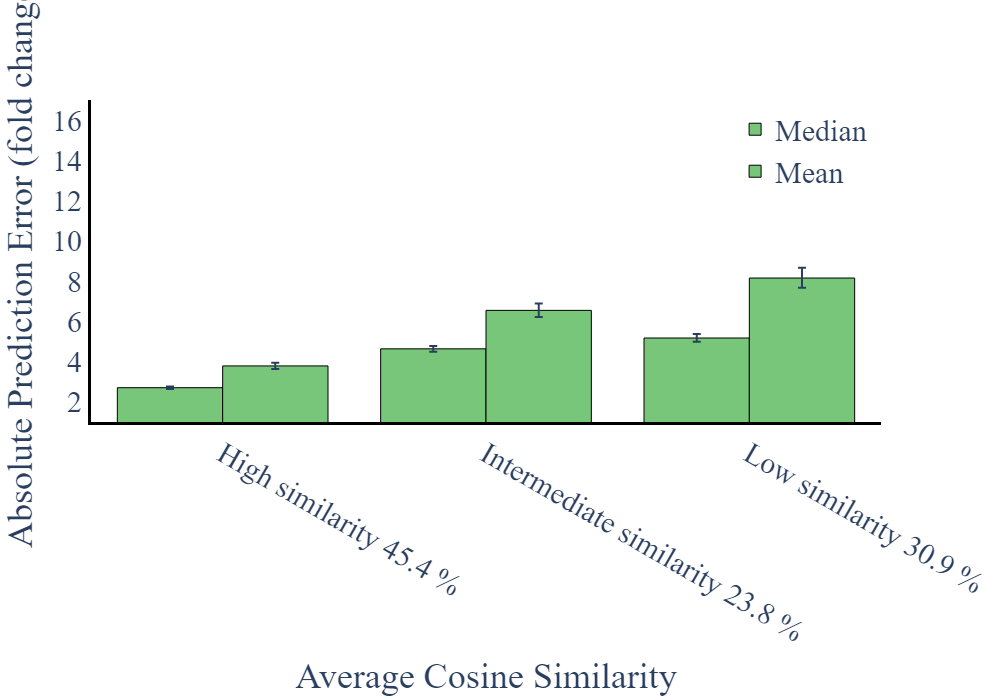

EC10_invertebrates 

[0.08311296 0.11182471 0.80506233]


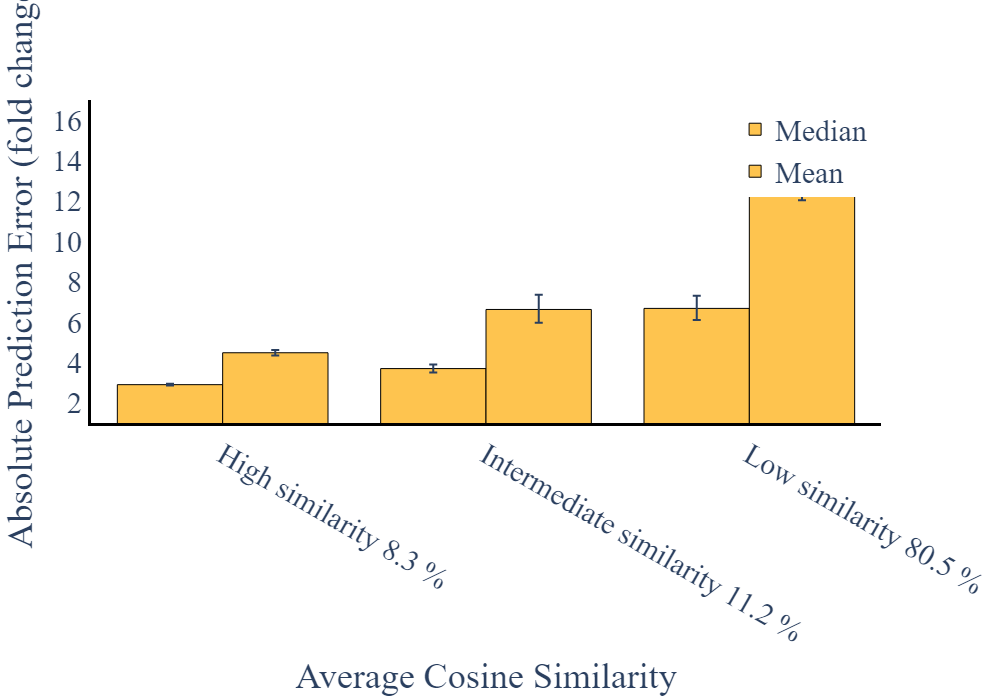

EC10_fish 

[0.18267988 0.19689789 0.62042223]


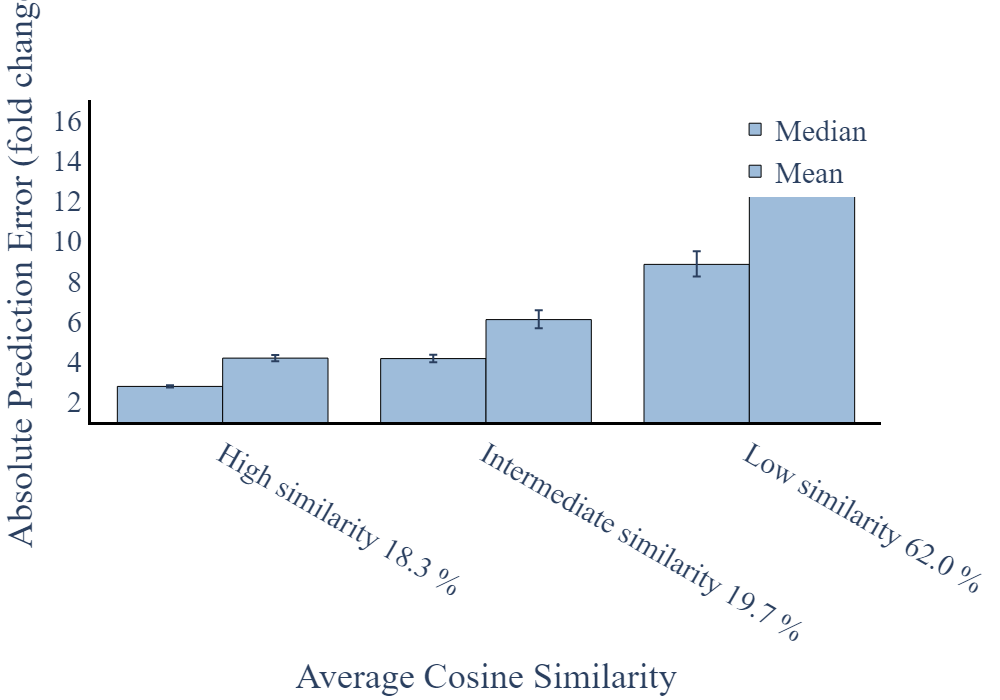

EC50_algae 

[0.40028139 0.28455856 0.31516004]


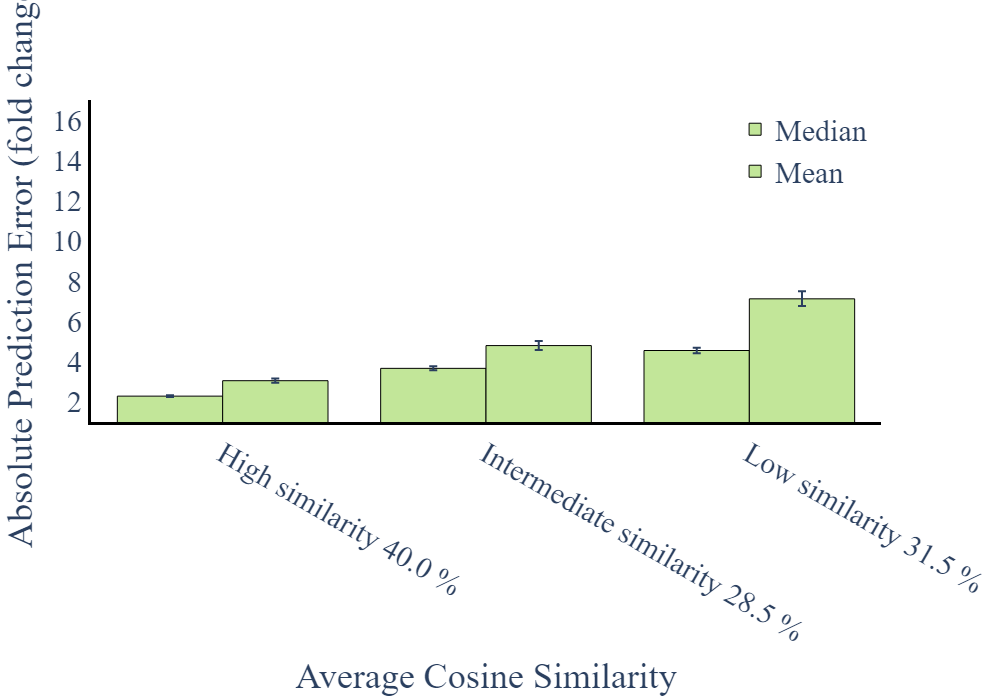

EC50_invertebrates 

[0.37530072 0.43036621 0.19433307]


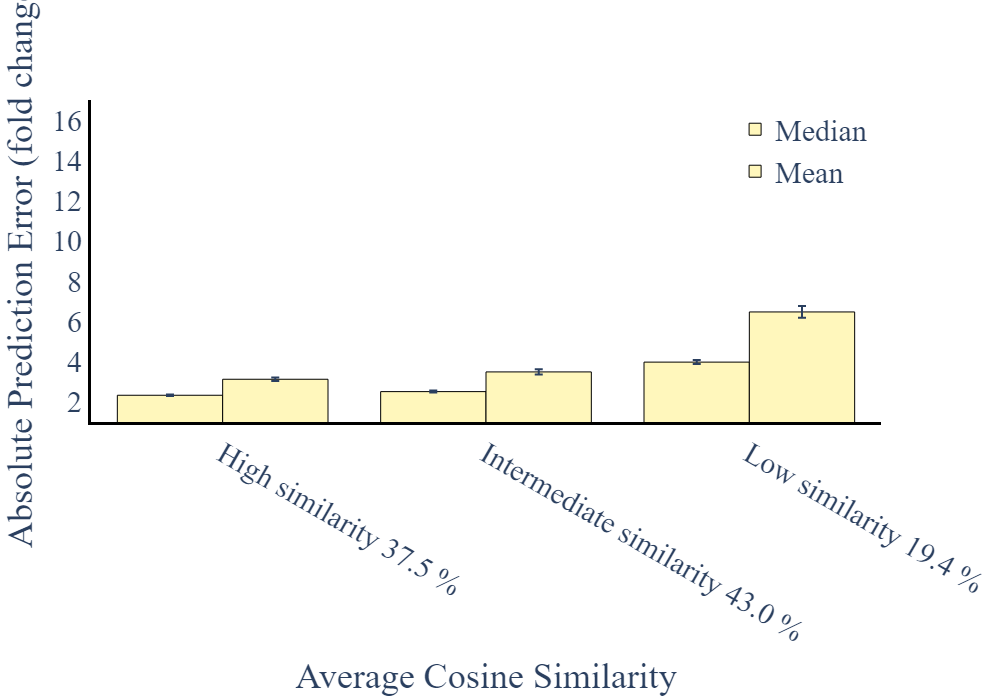

EC50_fish 

[0.31507623 0.20073405 0.48418972]


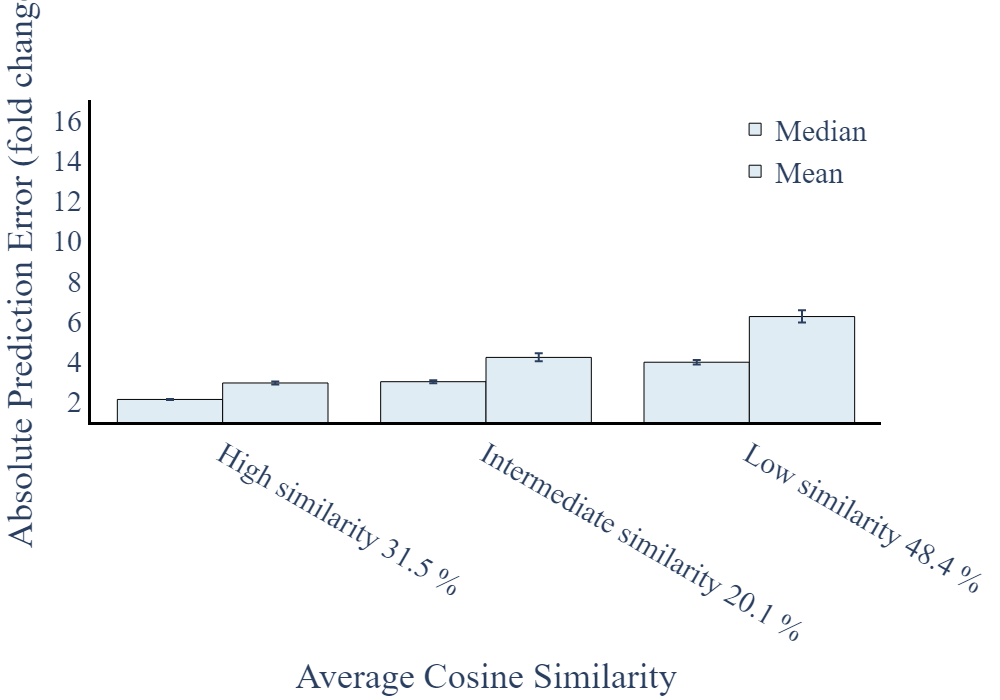

In [2]:
from figure_utils.trident_figures import PlotCosineSimilarityAndL1Error_med
for ENDPOINT in ['EC10', 'EC50']:
    for SPECIES_GROUP in ['algae','invertebrates', 'fish']:
        NAME = f'{ENDPOINT}_{SPECIES_GROUP}'
        print(NAME, '\n')
        PlotCosineSimilarityAndL1Error_med(savepath=f"./figures_for_publication/{ENDPOINT}/{NAME}_Cosine_similarity_Avg_with_median_0203", name=NAME, endpoint=ENDPOINT, species_group=SPECIES_GROUP, quantiles=None, bins=[-1,0.2,0.3,1])

In [ ]:
for ENDPOINT in ['EC50','EC10']:
    PlotCosineSimilarityAndL1ErrorAllInOne(savepath=f"./figures_for_publication/{ENDPOINT}/Cosine_similarity_Avg_allinone", endpoint=ENDPOINT, bins=[-1,0.2,0.3,1])